# Bert Attentionとresnet Gradcamで判断部位を可視化

## ライブラリインポート

In [1]:
# Grad-CAM
from gradcam import GradCAM, GradCAMpp
from gradcam.utils import visualize_cam
# PyTorch Modules

from torchvision.utils import make_grid, save_image
import torch.optim as optim
import torchvision.models as models
from torch.utils.data.dataset import Subset
import torchvision.transforms as transforms
from torchvision import transforms, datasets
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torch

# Basic Modules
# import os
import argparse
import numpy as np
import pandas as pd
import time
from PIL import Image
import glob
import pickle
import matplotlib.pyplot as plt
from IPython.display import HTML
import gc

# mmbt
from mmbt.data.helpers import get_data_loaders_for_production
from mmbt.data.helpers import get_data_loaders
import mmbt.train_sales_forecast as train
from mmbt.utils.utils import *
from mmbt.models import get_model
from mmbt.data import *
from scripts import ebay
pd.set_option("display.max_colwidth", 80)

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.
Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [2]:
# 関数インポート
# 推論
# 可視化
# 結果保存

## 関数定義

In [3]:
def fix_seed(seed):
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

SEED = 1
fix_seed(SEED)

In [4]:
# pickleを保存
def save_pickle(obj, path):
    with open(path, mode='wb') as f:
        pickle.dump(obj, f)

# pickleをロード
def load_pickle(path):
    with open(path, mode='rb') as f:
        obj = pickle.load(f)
    return obj

def get_criterion(args):

    criterion = nn.CrossEntropyLoss()
    return criterion

# HTMLを作成する関数を実装
def highlight(word, attn):
    "Attentionの値が大きいと文字の背景が濃い赤になるhtmlを出力させる関数"

    html_color = '#%02X%02X%02X' % (
        255, int(255*(1 - attn)), int(255*(1 - attn)))
    return '<span style="background-color: {}"> {}</span>'.format(html_color, word)

def mk_html(index, df):
    "HTMLデータを作成する"
    df = df.reset_index(drop=True)
    attention_probs = df_not_correct.iloc[index]['attention_probs']
    normlized_weights = attention_probs[:, :, 5:]  # attention_probsのbert部分を抽出

    # indexの結果を抽出
    sentence = df['text'][index].split(' ')  # 文章
    label = df['tgts'][index]  # ラベル
    pred = df['preds'][index]  # 予測
    ctg_name = df['ctg_name'][index]
    pred_ctg_name = df['pred_ctg_name'][index]

    # ラベルと予測結果を文字に置き換え
    label_str = str(label)
    pred_str = str(pred)

    # 表示用のHTMLを作成する
    html = '正解ラベル：{}&nbsp;推論ラベル：{}<br>'.format(label_str, pred_str)
    html += '正解カテゴリー名：{}&nbsp;<br>推論カテゴリー名：{}<br>'.format(ctg_name, pred_ctg_name)
    # Self-Attentionの重みを可視化。Multi-Headが12個なので、12種類のアテンションが存在
    for i in range(12):

        # indexのAttentionを抽出と規格化
        # 0単語目[CLS]の、i番目のMulti-Head Attentionを取り出す
        # indexはミニバッチの何個目のデータかをしめす
        attens = normlized_weights[i, 0, :]
        attens = attens.detach()
        attens /= attens.max()

    # 12種類のAttentionの平均を求める。最大値で規格化
    all_attens = attens*0  # all_attensという変数を作成する
    for i in range(12):
        all_attens += normlized_weights[i, 0, :]
        all_attens = all_attens.detach()
    all_attens /= all_attens.max()

    html += '[BERTのAttentionを可視化_ALL]<br>'
    for word, attn in zip(sentence, all_attens):
        #         print(word)

        # 関数highlightで色をつける、関数tokenizer_bert.convert_ids_to_tokensでIDを単語に戻す
        html += highlight(word, attn)
    html += "<br><br>"

    return html

In [5]:
# gradcamに与えるモデルのクラスを定義
class Resnet(nn.Module):
    def __init__(self):
        super(Resnet, self).__init__()
        self.img_encoder = model.enc.img_encoder
        self.img_embeddings = model.enc.img_embeddings
        self.num_image_embeds = 5

    def forward(self, img_input):

        img_tok = (
            torch.LongTensor(1, self.num_image_embeds)
            .fill_(0).to(device)
        )
        img = self.img_encoder(img_input).to(
            device)  # BxNx3x224x224 -> BxNx2048
        img = self.img_embeddings(img, img_tok).to(device)
        return torch.flatten(img, start_dim=1).to(device)


class Resnet(nn.Module):
    def __init__(self):
        super(Resnet, self).__init__()
        self.img_encoder = model.enc.img_encoder
        self.img_embeddings = model.enc.img_embeddings

    def forward(self, img_input):

        img = self.img_encoder(img_input)  # BxNx3x224x224 -> BxNx2048
# print(img.sum())
        return torch.flatten(img, start_dim=1)

# gradcamの結果返す関数
def get_grid_image(img_path, model):

    target_layer = model.enc.img_encoder.model[4]
    resnet = Resnet()
    gradcam = GradCAM(resnet, target_layer)
    gradcam_pp = GradCAMpp(resnet, target_layer)
    images = []

    img = Image.open(img_path)
    torch_img = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])(img)
    normed_torch_img = transforms.Normalize(
        [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None].to(device)
#     print(normed_torch_img.size())
#     print(normed_torch_img.sum())
    mask, _ = gradcam(normed_torch_img)
    heatmap, result = visualize_cam(mask, torch_img)
    gradcam_dict = {}
    mask_pp, _ = gradcam_pp(normed_torch_img)
    heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)

    gradcam_dict['mask_pp'] = mask_pp
    gradcam_dict['heatmap_pp'] = result_pp
    gradcam_dict['result_pp'] = result_pp

    images.extend([torch_img.cpu(), heatmap, heatmap_pp, result, result_pp])
    grid_image = make_grid(images, nrow=5)
    return grid_image, gradcam_dict


def gc_collect(x):
    del x
    gc.collect()

In [6]:
# attention可視化結果を描写
def get_attention_img(model,index,df):
    # bertの注目箇所をgradcamで表示
    html_output = mk_html(index, df)
    HTML(html_output)
    return HTML(html_output)

# gardcamの結果を描写
def get_gradcam_img(model,index,df):
    img_path = df.iloc[index]['img']
    grid_image,gradcam_dict = get_grid_image(img_path,model)
    # resnetの注目箇所をgradcamで表示
    transforms.ToPILImage()(grid_image)

    return transforms.ToPILImage()(grid_image)

# ↓一つのセルにHTMLを表示＆保存したい
def get_attention_and_gradcam_img(model,index,df):
    img_path = df.iloc[index]['img']
    grid_image,gradcam_dict = get_grid_image(img_path,model)
    # resnetの注目箇所をgradcamで表示
    transforms.ToPILImage()(grid_image)
    # bertの注目箇所をgradcamで表示
    html_output = mk_html(index, df)
    HTML(html_output)
    return HTML(html_output),transforms.ToPILImage()(grid_image)

## 実行

In [7]:
# データロード
data_dict = load_pickle('./tmp/data_dict.pkl')
attention_probs = load_pickle('./savedir/ebay_codes_20210815_message_prediction/mmbt_model_run/test_attention_probs.pkl')
dataloaders_dict = load_pickle('./savedir/ebay_codes_20210815_message_prediction/mmbt_model_run/test_dataloaders_dict.pkl')
detail_list = load_pickle('./savedir/ebay_codes_20210815_message_prediction/mmbt_model_run/detail_list.pkl')

# テストデータを加工
df_test = data_dict['test']
target_dataset = 'ebay_codes_20210815_message_prediction' # データセット名
df = pd.read_table('./datasets/'+target_dataset+'/data.tsv') # 元データの読み込み
df_uniques = df[["ctg", "ctg_name"]].drop_duplicates() # カテゴリー番号、カテゴリー名のユニークなテーブル
df_uniques.ctg = df_uniques.ctg.astype(str)
df_uniques = df_uniques[df_uniques['ctg'].isin(['45258','15709','31387','52357'])] # 対象となるカテゴリーに絞る
df_test = pd.merge(df_test,df_uniques,left_on='label',right_on='ctg') # カテゴリー名を結合

gc_collect(df) # 変数初期化

# attention_probsをカラムに追加
df_test['number'] = df_test.index # ※ここの処理をいい感じにしたい
df_test['attention_probs'] = df_test['number'].apply(lambda x: attention_probs[x])

# データローダーのバッチデータを取得
feature = ['key', 'text_ids', 'segment_tensor',
           'mask', 'img_transformed', 'tgt']
df_batch = pd.DataFrame(index=[], columns=feature)
for batch in dataloaders_dict['test']:
    batch_normal = []
    for data in batch:
        listed_data = data.tolist()
        batch_normal.append(listed_data)
    df_batch_mini= pd.DataFrame(np.array(batch_normal).T, columns=feature)
    df_batch = pd.concat([df_batch,df_batch_mini])
df_batch = df_batch.astype({'key': int})

# df_test に対して推論結果やカテゴリー名を加える
df_test = df_test.drop(["ctg"],axis=1)
df_test = pd.merge(df_test, df_batch, left_on='key', right_on='key',how='left') # 元データに推論結果を結合
df_dital = pd.DataFrame(detail_list,index=['losses', 'preds', 'tgts', 'preds_score'])
df_dital = df_dital.T
df_test = pd.concat([df_test,df_dital],axis=1).reset_index(drop=True)
df_test['correct_flg'] = (df_test['tgts'] == df_test['preds'])
df_test['correct_flg'] = df_test['correct_flg'].astype(int)
df_uniques = df_test[["ctg_name","tgt"]].drop_duplicates() 
df_uniques = df_uniques.rename(columns={'ctg_name': 'pred_ctg_name'})
df_uniques = df_uniques.rename(columns={'tgt': 'pred_tgt'})
df_test = pd.merge(df_test,df_uniques,left_on='preds',right_on='pred_tgt') # 推論結果に対してカテゴリー名を付与
df_not_correct = df_test[df_test['correct_flg']==0]
df_correct = df_test[df_test['correct_flg']==1]
df_not_correct.head()

C:\Users\atom\AppData\Local\Temp/ipykernel_3264/4138017955.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_batch_mini= pd.DataFrame(np.array(batch_normal).T, columns=feature)


,label,text,img,date,std_price,key,ctg_name,number,attention_probs,text_ids,...,mask,img_transformed,tgt,losses,preds,tgts,preds_score,correct_flg,pred_ctg_name,pred_tgt
194,45258,bottega veneta leader wallet intrecha g round fasna reza 114076 ka ki made in,./datasets/ebay_codes_20210815_message_prediction/images/324726341528.jpg,07,-0.757496,4134,"Clothing, Shoes & Accessories:Women:Women's Accessories:Wallets",715,"[[[tensor(0.0230, device='cuda:0'), tensor(0.0492, device='cuda:0'), tensor(...","[28516, 2618, 3654, 2310, 7159, 2050, 3003, 15882, 20014, 2890, 7507, 1043, ...",...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]","[[[4.354686737060547, 4.354686737060547, 4.354686737060547, 4.35468673706054...",2,None,0,2,"[0.30627555, 0.29472086, 0.15003593, 0.24896765]",0,"Clothing, Shoes & Accessories:Men:Men's Shoes:Athletic Shoes",0
291,52357,felisi 1845 briefcase hand bag business black 0413 mens shippingfree from japan,./datasets/ebay_codes_20210815_message_prediction/images/324729268932.jpg,07,-0.501679,4909,"Clothing, Shoes & Accessories:Men:Men's Accessories:Bags",1073,"[[[tensor(0.0317, device='cuda:0'), tensor(0.0388, device='cuda:0'), tensor(...","[10768, 6856, 2072, 9512, 21793, 2192, 4524, 2449, 2304, 5840, 17134, 2273, ...",...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[[[4.354686737060547, 4.354686737060547, 4.354686737060547, 4.35468673706054...",3,None,0,2,"[0.39260995, 0.16172856, 0.08402874, 0.36163276]",0,"Clothing, Shoes & Accessories:Men:Men's Shoes:Athletic Shoes",0
343,15709,adidas originals fv3260 yeezy boost 380 alien us9 1 2,./datasets/ebay_codes_20210815_message_prediction/images/324729484491.jpg,07,0.308086,617,"Clothing, Shoes & Accessories:Men:Men's Shoes:Athletic Shoes",22,"[[[tensor(0.0494, device='cuda:0'), tensor(0.0517, device='cuda:0'), tensor(...","[27133, 8883, 23728, 1042, 2615, 16703, 16086, 6300, 9351, 2100, 12992, 1701...",...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[[[3.552532911300659, 3.5846190452575684, 3.5846190452575684, 3.584619045257...",0,0.840081,2,3,"[0.08755915, 0.19053523, 0.38860112, 0.33330455]",0,"Clothing, Shoes & Accessories:Women:Women's Accessories:Wallets",2
359,15709,nike ct2815-200 unused items airfo s 1 air force gore-tex boots b tsu sho g ...,./datasets/ebay_codes_20210815_message_prediction/images/324726422648.jpg,07,-0.233742,1141,"Clothing, Shoes & Accessories:Men:Men's Shoes:Athletic Shoes",50,"[[[tensor(0.0297, device='cuda:0'), tensor(0.0269, device='cuda:0'), tensor(...","[18368, 14931, 22407, 16068, 1011, 3263, 15171, 5167, 2250, 14876, 1055, 101...",...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[[[4.354686737060547, 4.354686737060547, 4.354686737060547, 4.35468673706054...",0,None,2,3,"[0.047312237, 0.24296607, 0.54221094, 0.16751076]",0,"Clothing, Shoes & Accessories:Women:Women's Accessories:Wallets",2
362,15709,size nike a beautiful article lunar force 1 duckboot low sni ka logo reza,./datasets/ebay_codes_20210815_message_prediction/images/184962214158.jpg,07,-0.465188,1183,"Clothing, Shoes & Accessories:Men:Men's Shoes:Athletic Shoes",60,"[[[tensor(0.0405, device='cuda:0'), tensor(0.0461, device='cuda:0'), tensor(...","[2946, 18368, 1037, 3376, 3720, 11926, 2486, 1015, 9457, 27927, 2659, 1055, ...",...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[[[4.354686737060547, 4.354686737060547, 4.354686737060547, 4.35468673706054...",0,None,2,3,"[0.07524422, 0.17436457, 0.41221198, 0.3381792]",0,"Clothing, Shoes & Accessories:Women:Women's Accessories:Wallets",2


Clothing, Shoes & Accessories:Women:Women's Accessories:Wallets


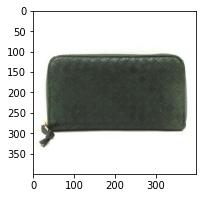

In [8]:

# 画像を描写
%matplotlib inline
for i in range(20):
    # Jupyterでインライン表示するための宣言
    img_path = df_not_correct.iloc[i]['img']
    # 画像の読み込み20
    im = Image.open(img_path)
    # 画像をarrayに変換
    im_list = np.asarray(im)
    # Figureの初期化
    fig = plt.figure(figsize=(4, 3)) #...1
    # 貼り付け
    plt.imshow(im_list)
    # 表示
    print(df_not_correct.iloc[i]['ctg_name'])
    plt.show()
    
    time.sleep(2)
    break

In [9]:
# gradcamに投入するモデルの設定

# 変数設定
target_dataset = 'ebay_codes_20210815_message_prediction'  # データセット名
target_col = 'ctg'  # 目的変数のカラム名（sold_flag/ctg）
model = 'mmbt'
bert_model = 'bert-base-uncased'  # bertモデル　bert-large-uncased　bert-base-uncased
image_model = 'resnet152'  # imageモデル ※将来的にresnet152以外のモデルを使う場合に使用
batch_sz = '32'  # 　32 バッチサイズ
max_epochs = '8'  # 学習回数
save_model_name = '_'+target_col + '_' + \
    'variables'+'_'+'ep'+max_epochs  # 保存するモデル名
n_classes = '4'
args = train.get_args(target_dataset, target_col, bert_model,
                      batch_sz, max_epochs, model, n_classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = get_model(args).to(device)
load_checkpoint(model, './savedir/'+target_dataset +
            '/mmbt_model_run/model_best.pt')
model.eval()

self.all_head_size 768


MultimodalBertClf(
  (enc): MultimodalBertEncoder(
    (txt_embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (img_embeddings): ImageBertEmbeddings(
      (img_embeddings): Linear(in_features=2048, out_features=768, bias=True)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (word_embeddings): Embedding(30522, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (img_encoder): ImageEncoder(
      (model): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, p

In [10]:
# BERTのAttentionを可視化
index = 0
df = df_not_correct
get_attention_img(model,index,df)

C:\Users\atom\Anaconda3\envs\py385\lib\site-packages\torch\nn\modules\module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
C:\Users\atom\Anaconda3\envs\py385\lib\site-packages\torch\nn\functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


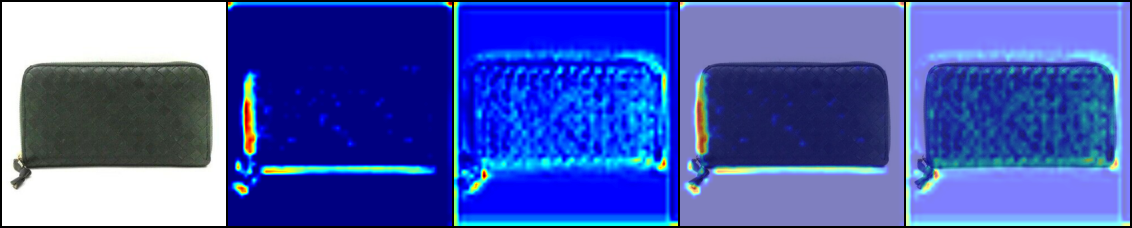

In [11]:
# gradcamでresnetの注目部分を可視化
df = df_not_correct
get_gradcam_img(model,index,df)